## Modello di riferimento: Naive Bayes per la classificazione dei ticket

In questo notebook viene analizzato un modello di classificazione testuale basato su **Multinomial Naive Bayes**, utilizzato come termine di confronto concettuale rispetto ad altri approcci lineari applicati allo stesso problema.

Il modello viene confrontato con:
- una pipeline **TF-IDF + Logistic Regression**, adottata come baseline,
- una pipeline **TF-IDF + Support Vector Machine lineare**, considerata come alternativa metodologica.

### Obiettivi della sperimentazione

Gli obiettivi di questa analisi sono i seguenti:
- valutare le prestazioni di **Multinomial Naive Bayes** nei due task di classificazione:
  - assegnazione della **categoria** (Amministrazione, Commerciale, Tecnico),
  - stima della **priorità** (bassa, media, alta);
- utilizzare la medesima rappresentazione testuale basata su **TF-IDF**, al fine di garantire coerenza metodologica nel confronto tra i modelli;
- analizzare i limiti strutturali del modello Naive Bayes rispetto agli approcci lineari discriminativi


In [1]:
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_it = stopwords.words('italian')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

# Opzionale: stile grafico più leggibile
sns.set(style="whitegrid")

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lavezzidie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Caricamento del dataset preprocessato

Il dataset `../data/tickets_preprocessed_split.csv` contiene:
- testo originale (`title`, `body`)
- testo combinato (`text`)
- versione pulita del testo (`text_clean`)
- etichette (`category`, `priority`)
- colonna `split` che distingue **train** e **test**


In [2]:
DATA_PATH = DATA_DIR / "splits" / "tickets_preprocessed_split.csv"

df = pd.read_csv(DATA_PATH)

df.head()

,id,title,body,category,priority,title_length,body_length,text,text_clean,len_words_raw,len_words_clean,split
0,1,Timeout ricerca: impossibile filtrare fatture ...,Proposta di manutenzione ordinaria: pulizia ac...,Amministrazione,media,57,256,Timeout ricerca: impossibile filtrare fatture ...,timeout ricerca impossibile filtrare fatture 3...,48,47,test
1,2,Backup: storico fatture 1997,Data entr:y modifica scheda informativa client...,Amministrazione,bassa,28,276,Backup: storico fatture 1997 Data entr:y modif...,backup storico fatture 1997 data entr y modifi...,37,40,train
2,3,Monitoraggio: log modulo utenti (nessun errore...,Il sistema ordini non risponde alle richieste ...,Amministrazione,alta,61,357,Monitoraggio: log modulo utenti (nessun errore...,monitoraggio log modulo utenti nessun errore l...,61,60,train
3,4,Manutenzione: pulizia account inattivi - login...,Nota di aggiornamento anagrafica per cliente G...,Amministrazione,media,72,300,Manutenzione: pulizia account inattivi - login...,manutenzione pulizia account inattivi login fa...,53,53,train
4,5,Manutenzione: pulizia account inattivi,Monitoraggio passivo dei log modulo gestione u...,Amministrazione,bassa,38,323,Manutenzione: pulizia account inattivi Monitor...,manutenzione pulizia account inattivi monitora...,48,48,test


In [3]:
# Verifica della colonna 'split'
df["split"].value_counts()


split
train    384
test      96
Name: count, dtype: int64


## Costruzione dei set di training e test

Separiamo feature e target usando `split`:
- `X_train` / `X_test`: testo pulito (`text_clean`)
- `y_train_cat` / `y_test_cat`: etichetta `category`
- `y_train_prio` / `y_test_prio`: etichetta `priority`

Come input testuale viene utilizzata la colonna `text_clean` contenente il testo già pulito.
Vengono verificare dimensioni e distribuzioni per assicurarsi che train e test restino comparabili.

In [4]:
# Feature testuale
X_train = df[df["split"] == "train"]["text_clean"]
X_test  = df[df["split"] == "test"]["text_clean"]

# Target per categoria
y_train_cat = df[df["split"] == "train"]["category"]
y_test_cat  = df[df["split"] == "test"]["category"]

# Target per priorità
y_train_prio = df[df["split"] == "train"]["priority"]
y_test_prio  = df[df["split"] == "test"]["priority"]

print("Dimensioni training:", X_train.shape[0])
print("Dimensioni test:", X_test.shape[0])

Dimensioni training: 384
Dimensioni test: 96


In [5]:
print("Distribuzione categoria - train:")
print(y_train_cat.value_counts(normalize=True).round(3))

print("\nDistribuzione categoria - test:")
print(y_test_cat.value_counts(normalize=True).round(3))

print("\nDistribuzione priorità - train:")
print(y_train_prio.value_counts(normalize=True).round(3))

print("\nDistribuzione priorità - test:")
print(y_test_prio.value_counts(normalize=True).round(3))


Distribuzione categoria - train:
category
Tecnico            0.451
Amministrazione    0.299
Commerciale        0.250
Name: proportion, dtype: float64

Distribuzione categoria - test:
category
Tecnico            0.448
Amministrazione    0.302
Commerciale        0.250
Name: proportion, dtype: float64

Distribuzione priorità - train:
priority
media    0.370
alta     0.339
bassa    0.292
Name: proportion, dtype: float64

Distribuzione priorità - test:
priority
media    0.375
alta     0.344
bassa    0.281
Name: proportion, dtype: float64


## Modello 1 – Classificazione **categoria** con TF-IDF + Naive Bayes

In questo modello:
- Pulizia base del testo ed esclusione termini troppo rari o troppo frequenti con **min_df** e **max_df**
- Rappresentazione del testo: **TF-IDF** con uni- e bi-grammi
- Classificatore: **LinearSVC** multiclasse
- Gestione delle feature utilizzate: `max_features=200"`
- Gestione di possibili sbilanciamenti: `class_weight="balanced"`

Questa combinazione costituisce la **baseline** per la classificazione di categoria.

### Nota metodologica

In letteratura, il modello Naive Bayes viene frequentemente applicato a rappresentazioni basate su **conteggi grezzi** dei termini (ad esempio tramite *CountVectorizer*).  
In questo lavoro, l’uso di **TF-IDF** è deliberato e motivato dall’esigenza di garantire un confronto diretto tra modelli che condividono la stessa rappresentazione delle feature testuali.  

In [6]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = "" if text is None else str(text)
        
    # minuscole (e togli lowercase=False dal TFIDF)
    text = text.lower()
    
    # rimuovi solo simboli non utili
    text = re.sub(r"[^\w\sàèéìòù]", " ", text)
    
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [7]:
pipe_cat_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=clean_text,
        stop_words=stop_it,
        lowercase=True,
        ngram_range=(1, 2),
        max_features=200,
        min_df=2,             
        max_df=0.8,
        strip_accents="unicode"
    )),
    ("clf", MultinomialNB(
        alpha=1.0  # smoothing di Laplace standard
    ))
])

pipe_cat_nb


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...00154C06DD620>
,tokenizer,None


In [8]:
pipe_cat_nb.fit(X_train, y_train_cat)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...00154C06DD620>
,tokenizer,None



### Valutazione del modello per categoria

Metriche considerate:
- **Accuracy**: quota di predizioni corrette sul test set
- **F1 macro**: media dell'F1 calcolata separatamente su ciascuna classe (tutte le classi pesano uguale)
- **Classification report**: precision, recall, F1 per classe
- **Matrice di confusione**: errori per coppia (vera classe, classe predetta)


In [9]:
y_pred_cat_nb = pipe_cat_nb.predict(X_test)

acc_cat_nb = accuracy_score(y_test_cat, y_pred_cat_nb)
f1_cat_nb = f1_score(y_test_cat, y_pred_cat_nb, average="macro")

print(f"Accuracy Naive Bayes (categoria): {acc_cat_nb:.3f}")
print(f"F1 macro Naive Bayes (categoria): {f1_cat_nb:.3f}")

print("\nClassification report Naive Bayes (categoria):")
print(classification_report(y_test_cat, y_pred_cat_nb))


Accuracy Naive Bayes (categoria): 0.906
F1 macro Naive Bayes (categoria): 0.899

Classification report Naive Bayes (categoria):
                 precision    recall  f1-score   support

Amministrazione       0.95      0.72      0.82        29
    Commerciale       0.92      0.96      0.94        24
        Tecnico       0.88      1.00      0.93        43

       accuracy                           0.91        96
      macro avg       0.92      0.89      0.90        96
   weighted avg       0.91      0.91      0.90        96



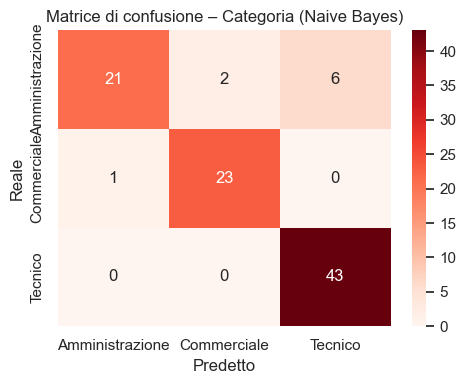

,Amministrazione,Commerciale,Tecnico
Amministrazione,21,2,6
Commerciale,1,23,0
Tecnico,0,0,43


In [10]:
labels_cat = sorted(y_train_cat.unique())

cm_cat_nb = confusion_matrix(y_test_cat, y_pred_cat_nb, labels=labels_cat)
cm_cat_nb_df = pd.DataFrame(cm_cat_nb, index=labels_cat, columns=labels_cat)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_cat_nb_df, annot=True, fmt="d", cmap="Reds")
plt.title("Matrice di confusione – Categoria (Naive Bayes)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

cm_cat_nb_df


## Modello 2 – Classificazione **priorità** con TF-IDF + LNaive Bayes

Replica dello stesso approccio utilizzato per la categoria, ma con target `priority`.

L’obiettivo è:
- capire quanto è più difficile stimare la priorità rispetto alla categoria
- confrontare le metriche delle due task (categoria vs priorità).



In [11]:
pipe_prio_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=clean_text,
        stop_words=stop_it,
        lowercase=True,
        ngram_range=(1, 2),
        max_features=200,
        strip_accents="unicode"
    )),
    ("clf", MultinomialNB(
        alpha=1.0
    ))
])

pipe_prio_nb


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...00154C06DD620>
,tokenizer,None


In [12]:
pipe_prio_nb.fit(X_train, y_train_prio)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...00154C06DD620>
,tokenizer,None



### Valutazione SVM per priorità

Stesse metriche della sezione categoria:
- Accuracy
- F1 macro
- Classification report
- Matrice di confusione

Confronto immediato con la baseline logistica anche sul target `priority`.


In [13]:
y_pred_prio_nb = pipe_prio_nb.predict(X_test)

acc_prio_nb = accuracy_score(y_test_prio, y_pred_prio_nb)
f1_prio_nb = f1_score(y_test_prio, y_pred_prio_nb, average="macro")

print(f"Accuracy Naive Bayes (priorità): {acc_prio_nb:.3f}")
print(f"F1 macro Naive Bayes (priorità): {f1_prio_nb:.3f}")

print("\nClassification report Naive Bayes (priorità):")
print(classification_report(y_test_prio, y_pred_prio_nb))


Accuracy Naive Bayes (priorità): 0.698
F1 macro Naive Bayes (priorità): 0.693

Classification report Naive Bayes (priorità):
              precision    recall  f1-score   support

        alta       0.74      0.79      0.76        33
       bassa       0.63      0.63      0.63        27
       media       0.71      0.67      0.69        36

    accuracy                           0.70        96
   macro avg       0.69      0.69      0.69        96
weighted avg       0.70      0.70      0.70        96



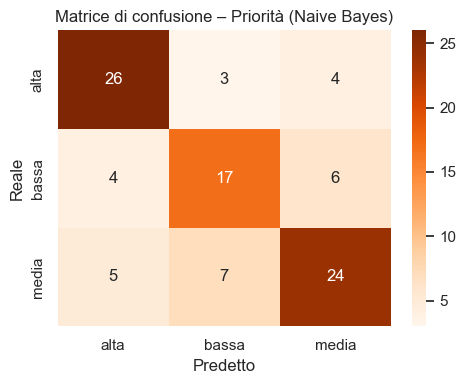

,alta,bassa,media
alta,26,3,4
bassa,4,17,6
media,5,7,24


In [14]:
labels_prio = sorted(y_train_prio.unique())

cm_prio_nb = confusion_matrix(y_test_prio, y_pred_prio_nb, labels=labels_prio)
cm_prio_nb_df = pd.DataFrame(cm_prio_nb, index=labels_prio, columns=labels_prio)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_prio_nb_df, annot=True, fmt="d", cmap="Oranges")
plt.title("Matrice di confusione – Priorità (Naive Bayes)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

cm_prio_nb_df


## Feature più influenti per classe

Per rendere il modello interpretabile:
- vengono estratte le feature TF-IDF e i coefficienti del `Naive Bayes`
- vengono mostrare le parole con score maggiore per ogni classe (categoria/priorità)
- l'output alimenta la dashboard con le *top 5 parole* associate a ciascuna etichetta

In [15]:
# Estrazione componenti dalla pipeline
vec_cat = pipe_cat_nb.named_steps["tfidf"]
clf_cat = pipe_cat_nb.named_steps["clf"]

feature_names_cat = np.array(vec_cat.get_feature_names_out())
classes_cat = clf_cat.classes_

top_k = 5

for idx, cls in enumerate(classes_cat):
    scores = clf_cat.feature_log_prob_[idx]
    top_idx = np.argsort(scores)[-top_k:][::-1]

    print(f"\nClasse categoria: {cls}")
    for i in top_idx:
        print(f"  {feature_names_cat[i]}  (score: {scores[i]:.3f})")



Classe categoria: Amministrazione
  fatture  (score: -4.232)
  cliente  (score: -4.436)
  errore  (score: -4.442)
  anagrafica  (score: -4.443)
  utenti  (score: -4.531)

Classe categoria: Commerciale
  cliente  (score: -3.619)
  crm  (score: -4.246)
  linea  (score: -4.269)
  ordine  (score: -4.350)
  invio  (score: -4.479)

Classe categoria: Tecnico
  ordini  (score: -4.006)
  modulo  (score: -4.395)
  solo  (score: -4.444)
  dati  (score: -4.451)
  attività  (score: -4.486)


In [16]:
vec_prio = pipe_prio_nb.named_steps["tfidf"]
clf_prio = pipe_prio_nb.named_steps["clf"]

feature_names_prio = np.array(vec_prio.get_feature_names_out())
classes_prio = clf_prio.classes_
top_k = 5

for idx, cls in enumerate(classes_prio):
    scores = clf_prio.feature_log_prob_[idx]
    top_idx = np.argsort(scores)[-top_k:][::-1]

    print(f"\nClasse priorità: {cls}")
    for i in top_idx:
        print(f"  {feature_names_prio[i]}  (score: {scores[i]:.3f})")


Classe priorità: alta
  cliente  (score: -3.943)
  ordine  (score: -4.058)
  urgente  (score: -4.223)
  bloccato  (score: -4.293)
  errore  (score: -4.293)

Classe priorità: bassa
  attività  (score: -4.123)
  magazzino  (score: -4.473)
  storico  (score: -4.495)
  richiesta  (score: -4.509)
  nessuna  (score: -4.548)

Classe priorità: media
  errore  (score: -4.334)
  bug  (score: -4.349)
  ordini  (score: -4.381)
  solo  (score: -4.392)
  cliente  (score: -4.518)



## Salvataggio delle metriche Naive Bayes

i risultati vengono esportati per essere riutilizzati nel notebook di confronto e nella dashboard:
- `nb_metrics.json` con accuracy/F1 macro per categoria e priorità
- `../data/results_baseline/confusion_*_nb.csv` con le matrici di confusione

In [17]:
import json

results_nb = {
    "categoria_accuracy": float(acc_cat_nb),
    "categoria_f1_macro": float(f1_cat_nb),
    "priorita_accuracy": float(acc_prio_nb),
    "priorita_f1_macro": float(f1_prio_nb)
}

with open(DATA_DIR / "results_baseline" / "nb_metrics.json", "w") as f:
    json.dump(results_nb, f, indent=4)

In [18]:
cm_cat_nb_df.to_csv(DATA_DIR / "results_baseline" / "confusion_cat_nb.csv", index=True)
cm_prio_nb_df.to_csv(DATA_DIR / "results_baseline" / "confusion_prio_nb.csv", index=True)

In [19]:
import numpy as np

TOP_N = 10
OUT_PATH = DATA_DIR / "results_baseline" / "topwords_nb.txt"
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)

def topwords_section_nb(title, clf, classes, feature_names, top_n=10):
    lines = [f"\n{title}\n" + "=" * len(title)]

    # feature_log_prob_[i, j] = log P(feature_j | class_i)
    for i, cls in enumerate(classes):
        logp = clf.feature_log_prob_[i]
        top_idx = np.argsort(logp)[-top_n:][::-1]
        lines.append(f"\nClasse: {cls}")
        lines += [f"  - {feature_names[j]} ({logp[j]:.3f})" for j in top_idx]

    return "\n".join(lines)

content = (
    "Top words - Multinomial Naive Bayes\n"
    + topwords_section_nb("Categoria", clf_cat, classes_cat, feature_names_cat, TOP_N)
    + topwords_section_nb("Priorità", clf_prio, classes_prio, feature_names_prio, TOP_N)
    + "\n"
)

OUT_PATH.write_text(content, encoding="utf-8")
print(f"[OK] Salvato: {OUT_PATH}")


[OK] Salvato: C:\project-work\data\results_baseline\topwords_nb.txt
